##Exploratory Data Analysis

**Import libraries**

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Download data from dropbox**

In [2]:
!wget -O  annotations.csv "https://www.dropbox.com/s/6wk6ajpvry9rd7z/annotations.csv?dl=0" --quiet
!wget -O  time_series.csv "https://www.dropbox.com/s/vnvz27bxkcojq0n/time_series.csv?dl=0" --quiet

**Load data**

In [3]:
# ## os.listdir()  # to check data downloaded correctly
# df_annot = pd.read_csv('annotations.csv')
# df_ts = pd.read_csv('time_series.csv')

In [4]:
from pandas import read_csv
ts = read_csv('time_series.csv')
print(type(ts))
print(ts.head())

annotation = read_csv('annotations.csv')
print(type(annotation))
print(annotation.head())

<class 'pandas.core.frame.DataFrame'>
   sub_001_ses_01_respiratory_chest  ...  sub_009_ses_10_respiratory_O2
0                         -0.200806  ...                       0.142212
1                         -0.221558  ...                       0.141602
2                         -0.238342  ...                       0.141602
3                         -0.251160  ...                       0.141907
4                         -0.259399  ...                       0.141907

[5 rows x 240 columns]
<class 'pandas.core.frame.DataFrame'>
                            ts_name  sampling_freq               type  type_num
0  sub_001_ses_01_respiratory_chest            100  respiratory_chest         1
1            sub_001_ses_01_cardiac            100            cardiac         2
2    sub_001_ses_01_respiratory_CO2            100    respiratory_CO2         3
3     sub_001_ses_01_respiratory_O2            100     respiratory_O2         4
4  sub_001_ses_02_respiratory_chest            100  respiratory_ches

In [5]:
# df_annot.head()

In [6]:
# df_ts.head()

**Basic info about the data**


Number of signals in total:

Number of samples per signal:

Number of signals in each class:

**Visualize a single signal**

In [7]:
# Choose a signal by its index

# Create time array

# Plot the signal


**Visualize a bunch of signals**

In [8]:
# Create subplot structure


# Plot several signals of each class



In [9]:
cardiac = ts.loc[:,['cardiac' in i for i in ts.columns]]
respiratory_chest = ts.loc[:,['respiratory_chest' in i for i in ts.columns]]
respiratory_CO2 = ts.loc[:,['respiratory_CO2' in i for i in ts.columns]]
respiratory_O2 = ts.loc[:,['respiratory_O2' in i for i in ts.columns]]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff145d0cb90>,
      dtype=object)

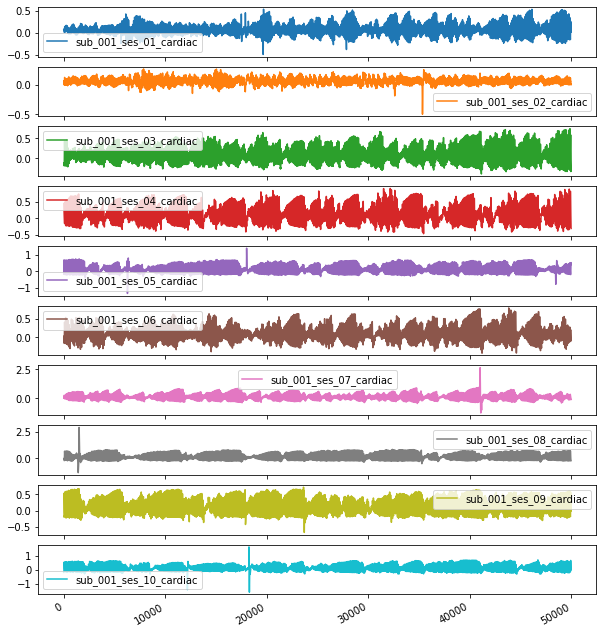

In [10]:
cardiac_s01 = cardiac.loc[:,['sub_001' in i for i in cardiac.columns]]
cardiac_s01.plot(subplots=True, figsize=(10, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff14543c4d0>,
      dtype=object)

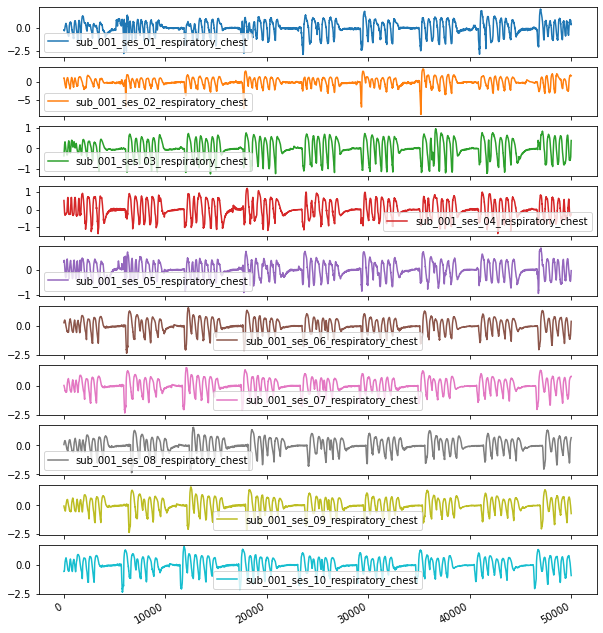

In [11]:
respc_s01 = respiratory_chest.loc[:,['sub_001' in i for i in respiratory_chest.columns]]
respc_s01.plot(subplots=True, figsize=(10, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff144059990>,
      dtype=object)

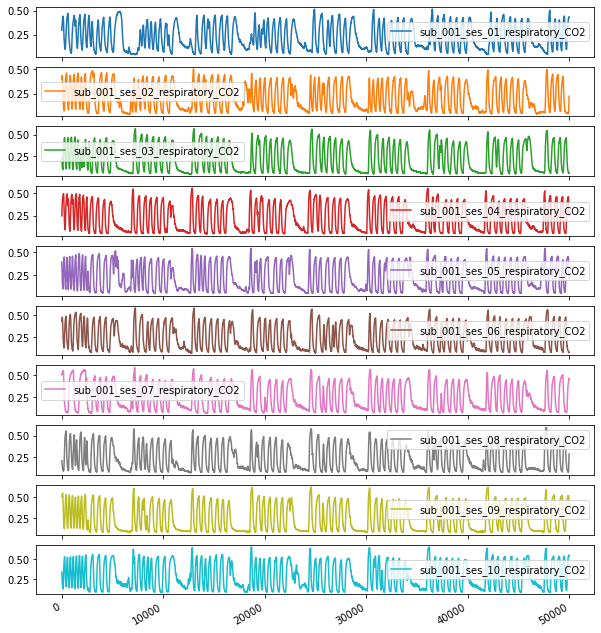

In [12]:
respco2_s01 = respiratory_CO2.loc[:,['sub_001' in i for i in respiratory_CO2.columns]]
respco2_s01.plot(subplots=True, figsize=(10, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff143f560d0>,
      dtype=object)

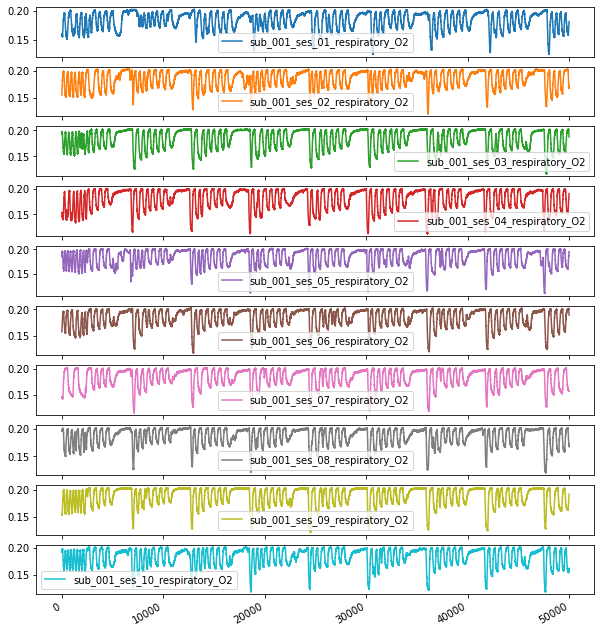

In [13]:
respo2_s01 = respiratory_O2.loc[:,['sub_001' in i for i in respiratory_O2.columns]]
respo2_s01.plot(subplots=True, figsize=(10, 12))

**Time-domain analysis**

In [14]:
# Loop through all signals in each class

# Compute mean, minimum and maximum

# Plot them in scatter plots

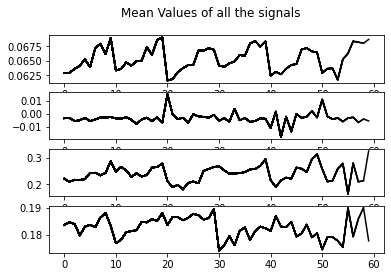

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4)
fig.suptitle('Mean Values of all the signals')

z_card = []
z_respch = []
z_respco2 = []
z_respo2 = []
index = ['cardiac','respiratory_chest','respiratory_CO2','respiratory_O2']
for (colname,colval) in ts.iteritems():
  if index[0] in colname:
    z_card.append(np.mean(colval.values))
    axs[0].plot(z_card, color='black') 
for (colname,colval) in ts.iteritems():
  if index[1] in colname:
    z_respch.append(np.mean(colval.values))
    axs[1].plot(z_respch, color='black')
for (colname,colval) in ts.iteritems():
  if index[2] in colname:
    z_respco2 .append(np.mean(colval.values))
    axs[2].plot(z_respco2, color='black') 
for (colname,colval) in ts.iteritems():
  if index[3] in colname:
    z_respo2.append(np.mean(colval.values))
    axs[3].plot(z_respo2, color='black') 
  

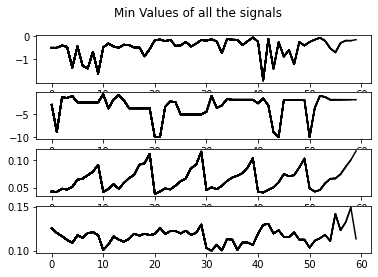

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4)
fig.suptitle('Min Values of all the signals')

z_card = []
z_respch = []
z_respco2 = []
z_respo2 = []
index = ['cardiac','respiratory_chest','respiratory_CO2','respiratory_O2']
for (colname,colval) in ts.iteritems():
  if index[0] in colname:
    z_card.append(min(colval.values))
    axs[0].plot(z_card, color='black') 
for (colname,colval) in ts.iteritems():
  if index[1] in colname:
    z_respch.append(min(colval.values))
    axs[1].plot(z_respch, color='black')
for (colname,colval) in ts.iteritems():
  if index[2] in colname:
    z_respco2 .append(min(colval.values))
    axs[2].plot(z_respco2, color='black') 
for (colname,colval) in ts.iteritems():
  if index[3] in colname:
    z_respo2.append(min(colval.values))
    axs[3].plot(z_respo2, color='black') 

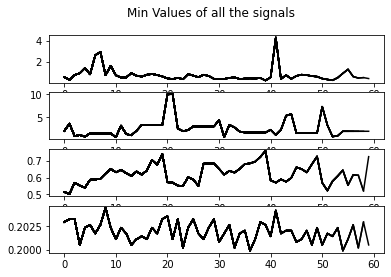

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4)
fig.suptitle('Min Values of all the signals')

z_card = []
z_respch = []
z_respco2 = []
z_respo2 = []
index = ['cardiac','respiratory_chest','respiratory_CO2','respiratory_O2']
for (colname,colval) in ts.iteritems():
  if index[0] in colname:
    z_card.append(max(colval.values))
    axs[0].plot(z_card, color='black') 
for (colname,colval) in ts.iteritems():
  if index[1] in colname:
    z_respch.append(max(colval.values))
    axs[1].plot(z_respch, color='black')
for (colname,colval) in ts.iteritems():
  if index[2] in colname:
    z_respco2 .append(max(colval.values))
    axs[2].plot(z_respco2, color='black') 
for (colname,colval) in ts.iteritems():
  if index[3] in colname:
    z_respo2.append(max(colval.values))
    axs[3].plot(z_respo2, color='black') 

**Frequency analysis**

In [18]:
# Loop through all signals

# Subtract the mean (maybe)

# Compute fft

# Plot spectrum

Text(0.5, 0, 'Hz')

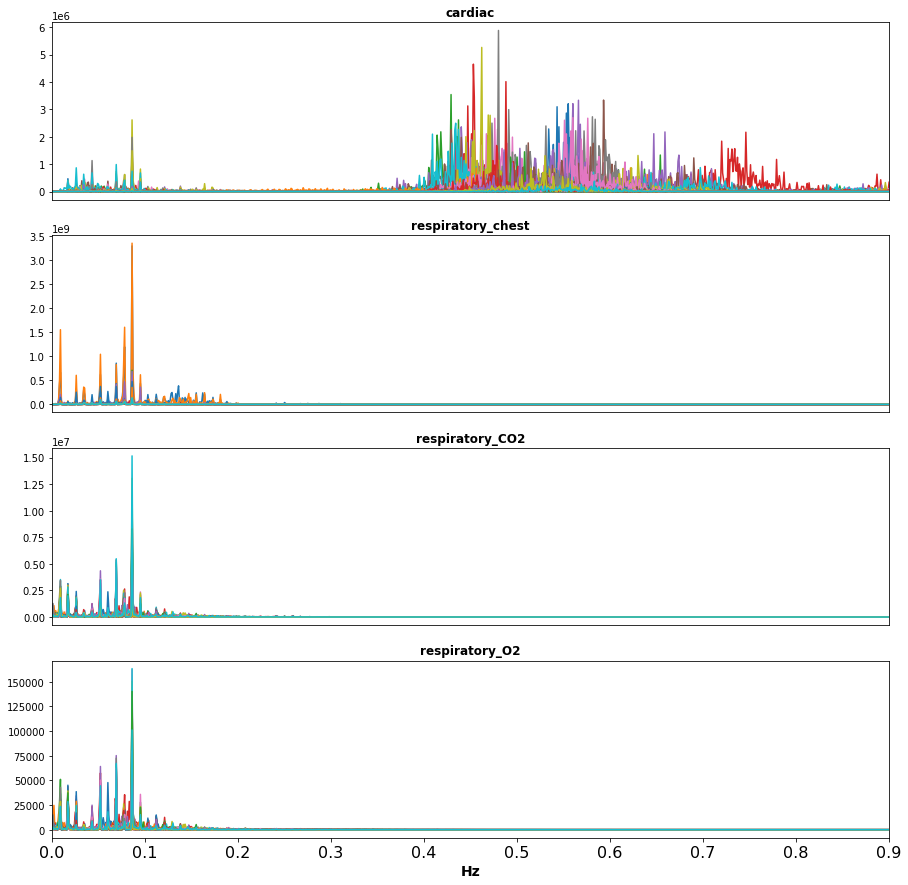

In [41]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, figsize=(15,15))
#fig.suptitle('Power spectrum of all the signals')
index = ['cardiac','respiratory_chest','respiratory_CO2','respiratory_O2']
for (colname,colval) in ts.iteritems():
  if index[0] in colname:
    x = np.asarray(colval.values)
    x = x - np.mean(x)
    fourier_transform = np.fft.fft(x)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, 100/2, len(power_spectrum))
    axs[0].plot(frequency, power_spectrum) 
    axs[0].set_xlim(0,0.9)
for (colname,colval) in ts.iteritems():
  if index[1] in colname:
    x = np.asarray(colval.values)
    x = x - np.mean(x)
    fourier_transform = np.fft.fft(x)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, 100/2, len(power_spectrum))
    axs[1].plot(frequency, power_spectrum)
    axs[1].set_xlim(0,0.9)
for (colname,colval) in ts.iteritems():
  if index[2] in colname:
    x = np.asarray(colval.values)
    x = x - np.mean(x)
    fourier_transform = np.fft.fft(x)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, 100/2, len(power_spectrum))
    axs[2].plot(frequency, power_spectrum) 
    axs[2].set_xlim(0,0.9)

for (colname,colval) in ts.iteritems():
  if index[3] in colname:
    x = np.asarray(colval.values)
    x = x - np.mean(x)
    fourier_transform = np.fft.fft(x)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, 100/2, len(power_spectrum))
    axs[3].plot(frequency, power_spectrum) 
    axs[3].set_xlim(0,0.9)

[ax.set_title(index[i],fontweight='bold') for i, ax in enumerate(axs)]
[ax.set_xticks([]) for ax in axs[:-1]]
axs[-1].xaxis.set_tick_params(labelsize=16)

axs[-1].set_xlabel('Hz',fontsize=14,fontweight='bold')
  

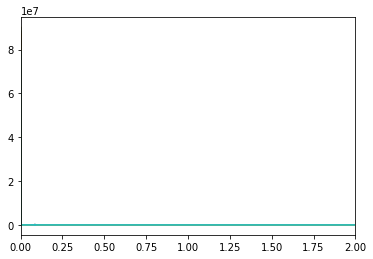

In [20]:
index = ['cardiac','respiratory_chest','respiratory_CO2','respiratory_O2']
for (colname,colval) in ts.iteritems():
  if index[3] in colname:
    x = np.asarray(colval.values)
    y = np.array(x[0])
    # print(type(y))
    fourier_transform = np.fft.fft(x)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, 100/2, len(power_spectrum))
    plt.plot(frequency, power_spectrum)
    plt.xlim(0,2)